# Goal: Preprocess Mass Spectra for Machine Learning Dataset Creation

The goal of this script is to plot the data web scraped from NIST. There are some details that need to be accounted for as we convert the data from the web scraping into something that can be used with our machine learning methods.

For this example we are working with CAS# 50066, phenobarbital. The chemical structure is shown below. (NIST Webbook)

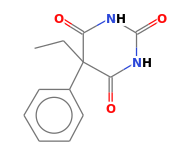

Here is the Mass Spectrum (NIST Webbook)

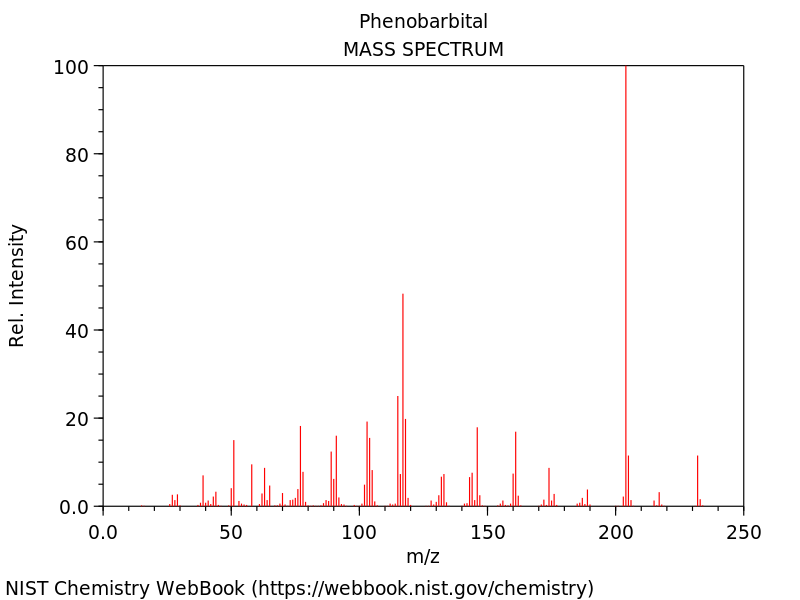

First we will pull in the data that has already been Webscraped for this compound. The only preprocessing done to this point has been to convert the downloded data from jcamp to a csv file.

In [1]:
import csv
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
#Change Path to Location of File
path = r'PATH'

In [4]:
spectrum = pd.read_csv(path + '\\'+'50066.csv')

We can see the spectrum as a data frame to make sure everyting looks correct.

In [5]:
spectrum

,mass,50066
0,15.0,20.0
1,16.0,10.0
2,26.0,50.0
3,27.0,260.0
4,28.0,140.0
...,...,...
135,219.0,10.0
136,231.0,10.0
137,232.0,1151.0
138,233.0,160.0


## Can we plot reasonably without defining every mass?

### Line Spectrum

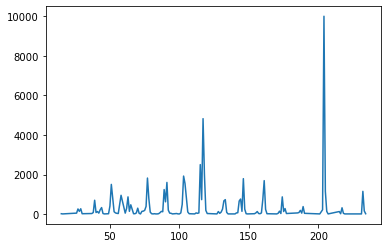

In [6]:
plt.plot(spectrum['mass'], spectrum['50066'])

No, we cannot what we get in the plot is broad triangles connecting peaks to eachother. In the grey scale image all of the peaks are butted up against eachother making the location on the image no longer correlated to the mass of that peak.

We can also take this time to normalize our spectrum to the highest intensity so that it is easier to compare with other mass spectra later.

## Reindexing to Add Back In Missing Values

First we need to reindex the array using 0 and the largest reported mass peak as our boundary conditions.

In [7]:
#Before we add in any missing values lets determine what the max intensity was so that we can normalize our entire spectra.
max_intensity = max(spectrum['50066'])
spectrum['50066'] = spectrum['50066'].div(max_intensity)
# First define our boundary conditions for what we want for the array, by generating a range from 1 to a given max mass
max_mass = 300
new_index = range(1, int(max_mass + 1))
#Now we send the current file information to a list so we can append more information.
mass = spectrum['mass'].tolist()
y = spectrum['50066'].tolist()
# Now we are going to make a for loop that will investigate each value of our new_index to determine what is and isn't currently present
for i in new_index:
    if i not in mass:
        mass.append(i)
        y.append(np.nan)
#Now that we have lists of our data that contains every mass value we can zip those lists together to recreate a dataframe
new_spectrum = zip(mass, y)
new_spectrum = pd.DataFrame(new_spectrum, columns = ['mass', 'intensity'])
#Now we can sort the data to put the masses in order
new_spectrum.sort_values(by=["mass"], inplace = True)

In [8]:
new_index

range(1, 301)

In [9]:
new_spectrum

,mass,intensity
140,1.0,NaN
141,2.0,NaN
142,3.0,NaN
143,4.0,NaN
144,5.0,NaN
...,...,...
295,296.0,NaN
296,297.0,NaN
297,298.0,NaN
298,299.0,NaN


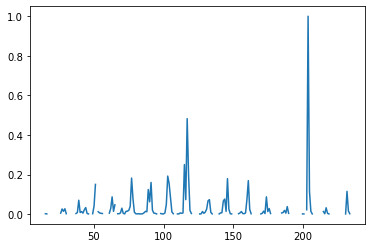

In [10]:
plt.plot(new_spectrum['mass'], new_spectrum['intensity'])

NOTE: When plotting the spectra the increased mass range will not affect the plotting of the spectra because we are adding NAN values rather than 0. Becuase there is no data in that place it will not cause the auto scaling of the x and y axis to happen.

Now we have a mass spectrum that accurately depics the amount of data that we have from NIST while also preserving the shape both of the data array and of the peaks themselves.

# Goal: Code that will allow me to drop one of my rows at a time to drop one mass unit at a time

Next our goal is to generate a method to drop one mass unit at a time from our analysis. The goal here is to generate an explanation as to what peaks are being utilized for our logistic regression approach.

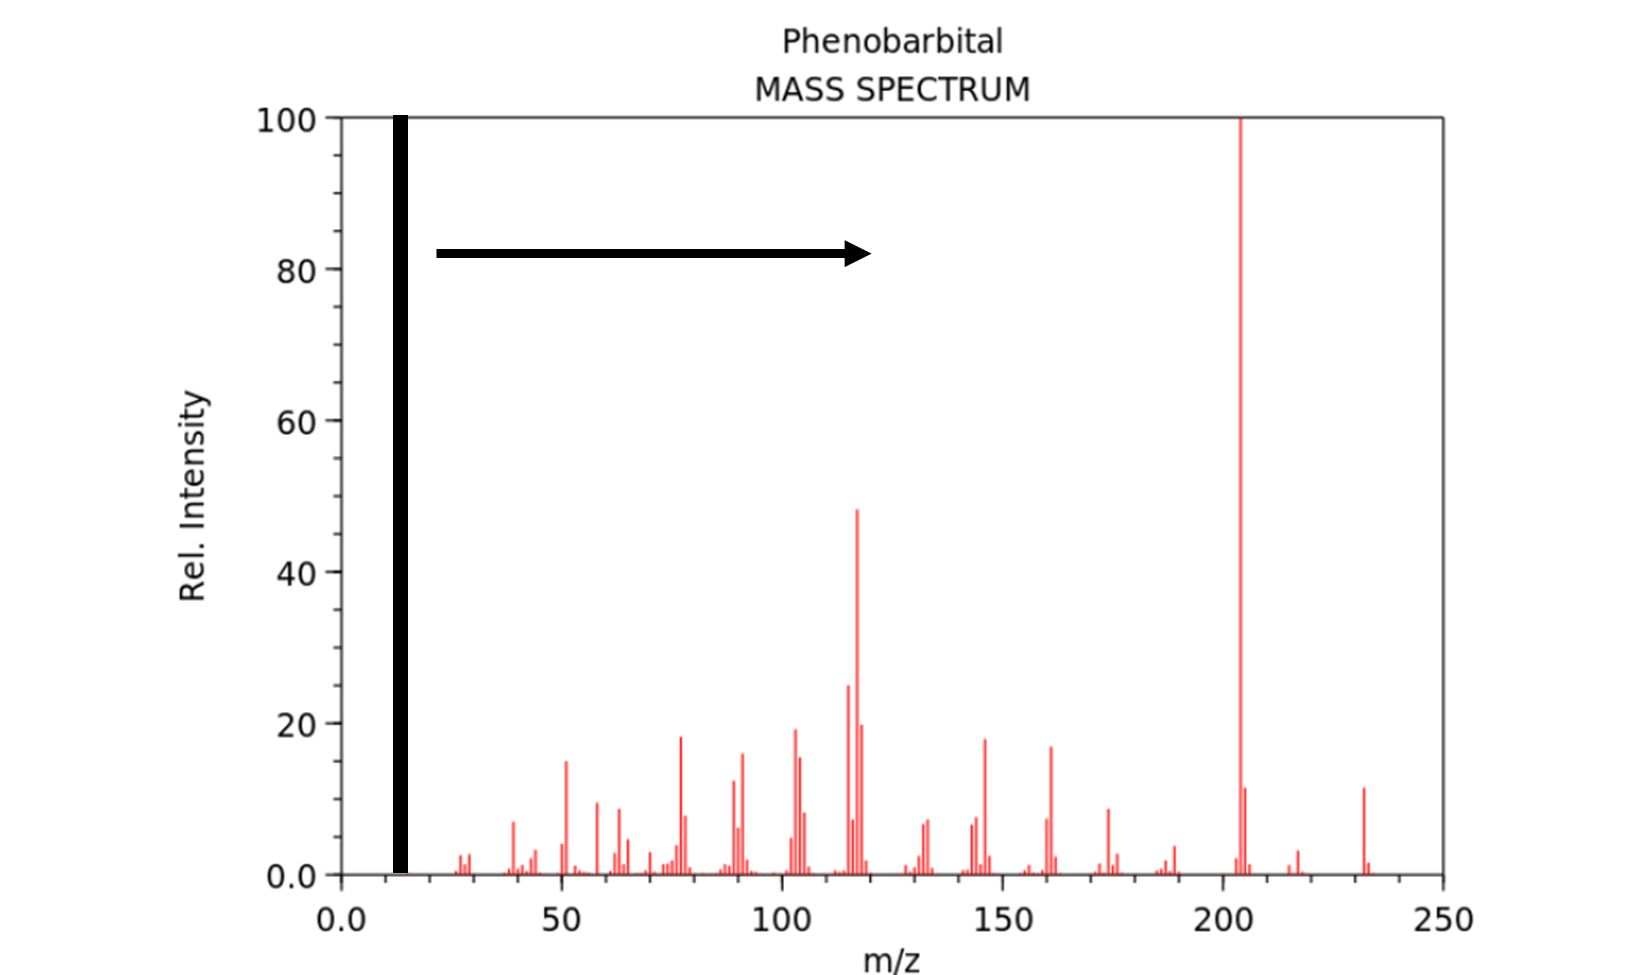

We will evaluate the accuracy of the LR models with the elimination of each of the different mass units and compare the final testing accuracy with the model that had access to all of the mass units. Once we find the most impactful peak we will "permanantly" remove that peak. Making that accuracy the new standard. We will then repeat the process looking for the second most impactful peak. This process will be iteratively repeated until we are able to get a fingerprint for X% of the total accuracy accomplished with all of the mass units intact.

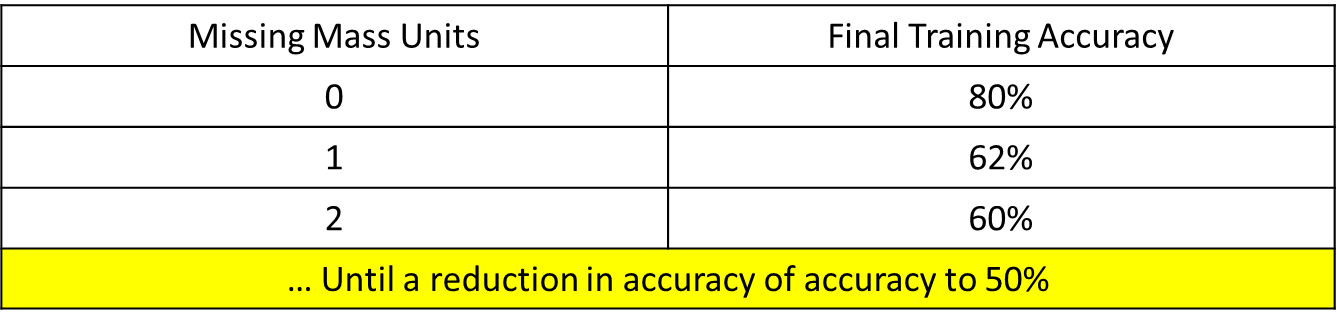

To do this we need a method that will generate a temporary data frame that is missing a row from the primary data frame.

In [11]:
total_dataframe = new_spectrum
for i in new_index:
    #index of dataframe starts at 0 new_index starts at 1
    i = i-1
    temp_dataframe = total_dataframe.drop([i])